In [1]:
import pandas as pd
from fuzzywuzzy import fuzz, process
import re
from datetime import datetime

# Load XLS file 
xls_path = 'All_Concerts_1908_filtered.xlsx'
xls_df = pd.read_excel(xls_path)

# Display the first few rows of the loaded DataFrame to verify
#print(xls_df.head(10))

# Load JSON file
json_path = 'Datasets/SD_DN_AB_1908_concerts_LLM.json'
json_df = pd.read_json(json_path)

# Verify the loaded JSON data
#print(json_df.head(3))

# Identify relevant columns
relevant_columns = ['konsert_datum', 'konsert_namn', 'lokal_namn', 'konsert_biljettpris', 'konserttyp_namn', 'Producer']

# Filter relevant columns
xls_df = xls_df[relevant_columns]
json_df = json_df[relevant_columns]

# Function to normalize text
def normalize(text):
    if pd.isna(text) or text.strip().lower() == "unknown":  # Handle NaN values and "UNKNOWN"
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[-,]', ' ', text)  # Replace hyphens and commas with spaces
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.strip()  # Remove leading and trailing spaces
    return text

# Function to normalize dates
def normalize_date(date):
    try:
        # Try to parse the date from different formats
        if isinstance(date, str):
            if re.match(r'\d{2}\.\d{2}\.\d{2}', date):  # Format: DD.MM.YY
                date_obj = datetime.strptime(date, '%d.%m.%y')
                if date_obj.year >= 2000:
                    date_obj = date_obj.replace(year=date_obj.year - 100)
            elif re.match(r'\d{4}\.\d{2}\.\d{2}', date):  # Format: YYYY.MM.DD
                date_obj = datetime.strptime(date, '%Y.%m.%d')
            elif re.match(r'\d{2}\.\d{2}\.\d{4}', date):  # Format: DD.MM.YYYY
                date_obj = datetime.strptime(date, '%d.%m.%Y')
            else:
                return ""
        elif isinstance(date, datetime):
            date_obj = date
        else:
            return ""
        return date_obj.strftime('%Y-%m-%d')  # Convert to "YYYY-MM-DD"
    except ValueError:
        return ""

# Normalize 'UNKNOWN' values and dates in both dataframes
xls_df = xls_df.replace('UNKNOWN', '')
json_df = json_df.replace('UNKNOWN', '')
xls_df['normalized_konsert_datum'] = xls_df['konsert_datum'].apply(normalize_date)
json_df['normalized_konsert_datum'] = json_df['konsert_datum'].apply(normalize_date)

# Normalize all text columns in both dataframes
for col in xls_df.columns:
    if xls_df[col].dtype == 'object':  # Apply only to text columns
        xls_df[col] = xls_df[col].apply(normalize)

for col in json_df.columns:
    if json_df[col].dtype == 'object':  # Apply only to text columns
        json_df[col] = json_df[col].apply(normalize)

# Columns to compare (excluding date)
columns_to_compare = ['konsert_namn', 'lokal_namn', 'konsert_biljettpris', 'konserttyp_namn', 'Producer']
print(xls_df.head(10))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


FileNotFoundError: File Datasets/SD_DN_AB_1908_concerts_LLM.json does not exist

In [8]:
from sklearn.model_selection import train_test_split
from collections import defaultdict
import numpy as np

# Function to perform fuzzy matching and return the best match
def find_best_match(test_record, train_records):
    best_score = 0
    best_match = None
    # Include the normalized date in the comparison
    all_columns_to_compare = columns_to_compare + ['normalized_konsert_datum']
    for index, train_record in train_records.iterrows():
        # Calculate a composite fuzzy score considering all relevant columns
        # Treat dates separately with exact matching for dates to give a bonus if they match exactly
        date_score = 100 if test_record['normalized_konsert_datum'] == train_record['normalized_konsert_datum'] else 0
        text_scores = [fuzz.ratio(test_record[col], train_record[col]) for col in columns_to_compare]
        avg_text_score = np.mean(text_scores)
        overall_score = np.mean([avg_text_score, date_score])
        if overall_score > best_score:
            best_score = overall_score
            best_match = train_record
    return best_match, best_score

# Split the data into training and testing sets
train_json_df, test_json_df = train_test_split(json_df, test_size=0.3, random_state=42)
train_xls_df, test_xls_df = train_test_split(xls_df, test_size=0.3, random_state=42)

# Assuming both datasets should have the same structure now
assert train_json_df.columns.tolist() == train_xls_df.columns.tolist(), "Columns do not match!"

# Concatenate the training data for a more robust model
combined_train_df = pd.concat([train_json_df, train_xls_df])

# Test each row in the test JSON dataset to find the best match in the combined training dataset
results = []
for _, test_record in test_json_df.iterrows():
    best_match, score = find_best_match(test_record, combined_train_df)
    results.append({
        'Test Record': test_record,
        'Best Match': best_match,
        'Score': score
    })

# Display the results
results_df = pd.DataFrame(results)
print(results_df[['Score']].describe())  # Summarize the scores to understand overall performance
results_df.head()  # Show sample results to inspect individual matches


            Score
count  416.000000
mean    85.717067
std     12.316420
min     44.600000
25%     76.275000
50%     85.550000
75%    100.000000
max    100.000000


,Test Record,Best Match,Score
0,konsert_datum ...,konsert_datum ...,78.9
1,konsert_datum ...,konsert_datum ...,100.0
2,konsert_datum ...,konsert_datum ...,73.0
3,konsert_datum ...,konsert_datum 04.04.08 kon...,80.5
4,konsert_datum ...,konsert_datum 2...,85.0


In [9]:
import pandas as pd
from fuzzywuzzy import fuzz
import numpy as np

# Define a function to compare a single JSON record against all XLS records
def compare_records(json_record, xls_df):
    best_score = 0
    best_match = None
    for _, xls_record in xls_df.iterrows():
        # Compute fuzzy match scores for each relevant field including the normalized date
        scores = [fuzz.ratio(json_record[col], xls_record[col]) for col in columns_to_compare + ['normalized_konsert_datum']]
        # Calculate the average score across all fields
        average_score = np.mean(scores)
        # std 
        if average_score > best_score:
            best_score = average_score
            best_match = xls_record
    return best_match, best_score

# Array to hold the results
results = []

# Iterate over each record in the JSON dataframe
for _, json_record in json_df.iterrows():
    match, score = compare_records(json_record, xls_df)
    results.append({
        'JSON Record': json_record.to_dict(),
        'Best XLS Match': match.to_dict(),
        'Fuzzy Score': score
    })

# Convert results to a DataFrame for easier viewing and analysis
results_df = pd.DataFrame(results)

# Display the average, min, and max fuzzy scores
print("Fuzzy Score Statistics:")
print(results_df['Fuzzy Score'].describe())

# Show the first few results to inspect
results_df.head()


Fuzzy Score Statistics:
count    1384.000000
mean       66.128131
std        10.952091
min        29.333333
25%        59.166667
50%        65.666667
75%        73.666667
max        98.333333
Name: Fuzzy Score, dtype: float64


,JSON Record,Best XLS Match,Fuzzy Score
0,"{'konsert_datum': '14.02.08', 'konsert_namn': ...","{'konsert_datum': 1908-02-17 00:00:00, 'konser...",89.666667
1,"{'konsert_datum': '13.02.08', 'konsert_namn': ...","{'konsert_datum': 1908-01-05 00:00:00, 'konser...",71.833333
2,"{'konsert_datum': '13.02.08', 'konsert_namn': ...","{'konsert_datum': 1908-03-01 00:00:00, 'konser...",80.333333
3,"{'konsert_datum': '18.01.08', 'konsert_namn': ...","{'konsert_datum': 1908-01-18 00:00:00, 'konser...",81.500000
4,"{'konsert_datum': '17.01.08', 'konsert_namn': ...","{'konsert_datum': 1908-01-17 00:00:00, 'konser...",68.500000


In [10]:
import pandas as pd
from fuzzywuzzy import process
import numpy as np

# Function to find the best match for each row in the JSON dataset against the XLS dataset
def find_best_match(json_df, xls_df):
    best_matches = []
    unmatched_records = []

    # Use a set to track matched dates in the XLS dataset
    matched_dates = set()

    for _, json_record in json_df.iterrows():
        best_score = 0
        best_match = None

        for _, xls_record in xls_df.iterrows():
            scores = [fuzz.ratio(json_record[col], xls_record[col]) for col in columns_to_compare + ['normalized_konsert_datum']]
            average_score = np.mean(scores)
            if average_score > best_score:
                best_score = average_score
                best_match = xls_record

        if best_score > 75:  # A threshold to consider as a valid match
            best_matches.append({
                'JSON Record': json_record.to_dict(),
                'Best XLS Match': best_match.to_dict(),
                'Fuzzy Score': best_score
            })
            matched_dates.add(json_record['normalized_konsert_datum'])
        else:
            unmatched_records.append(json_record)

    # Filter unmatched records to include only those with dates not found in the matched dates
    unmatched_with_dates = [record for record in unmatched_records if record['normalized_konsert_datum'] in matched_dates]

    return best_matches, unmatched_with_dates

# Perform the matching
matches, unmatched_with_same_date = find_best_match(json_df, xls_df)

# Export unmatched records with the same dates to a CSV
unmatched_df = pd.DataFrame(unmatched_with_same_date)
unmatched_df.to_csv('LLM_found_concerts.csv', index=False)

print(f"Exported {len(unmatched_with_same_date)} unmatched records with the same dates to 'LLM_found_concerts.csv'")


Exported 852 unmatched records with the same dates to 'LLM_found_concerts.csv'


In [14]:
results_df.head(10)

,JSON Record,Best XLS Match,Fuzzy Score
0,"{'konsert_datum': '14.02.08', 'konsert_namn': ...","{'konsert_datum': 1908-02-17 00:00:00, 'konser...",89.666667
1,"{'konsert_datum': '13.02.08', 'konsert_namn': ...","{'konsert_datum': 1908-01-05 00:00:00, 'konser...",71.833333
2,"{'konsert_datum': '13.02.08', 'konsert_namn': ...","{'konsert_datum': 1908-03-01 00:00:00, 'konser...",80.333333
3,"{'konsert_datum': '18.01.08', 'konsert_namn': ...","{'konsert_datum': 1908-01-18 00:00:00, 'konser...",81.500000
4,"{'konsert_datum': '17.01.08', 'konsert_namn': ...","{'konsert_datum': 1908-01-17 00:00:00, 'konser...",68.500000
5,"{'konsert_datum': '19.01.08', 'konsert_namn': ...","{'konsert_datum': 1908-01-19 00:00:00, 'konser...",75.666667
6,"{'konsert_datum': '06.02.08', 'konsert_namn': ...","{'konsert_datum': 1908-02-04 00:00:00, 'konser...",73.833333
7,"{'konsert_datum': '17.01.08', 'konsert_namn': ...","{'konsert_datum': 1908-01-19 00:00:00, 'konser...",62.833333
8,"{'konsert_datum': '', 'konsert_namn': 'jyfosik...","{'konsert_datum': 1908-12-31 00:00:00, 'konser...",72.333333
9,"{'konsert_datum': '', 'konsert_namn': 'kiarach...","{'konsert_datum': 1908-12-31 00:00:00, 'konser...",38.666667


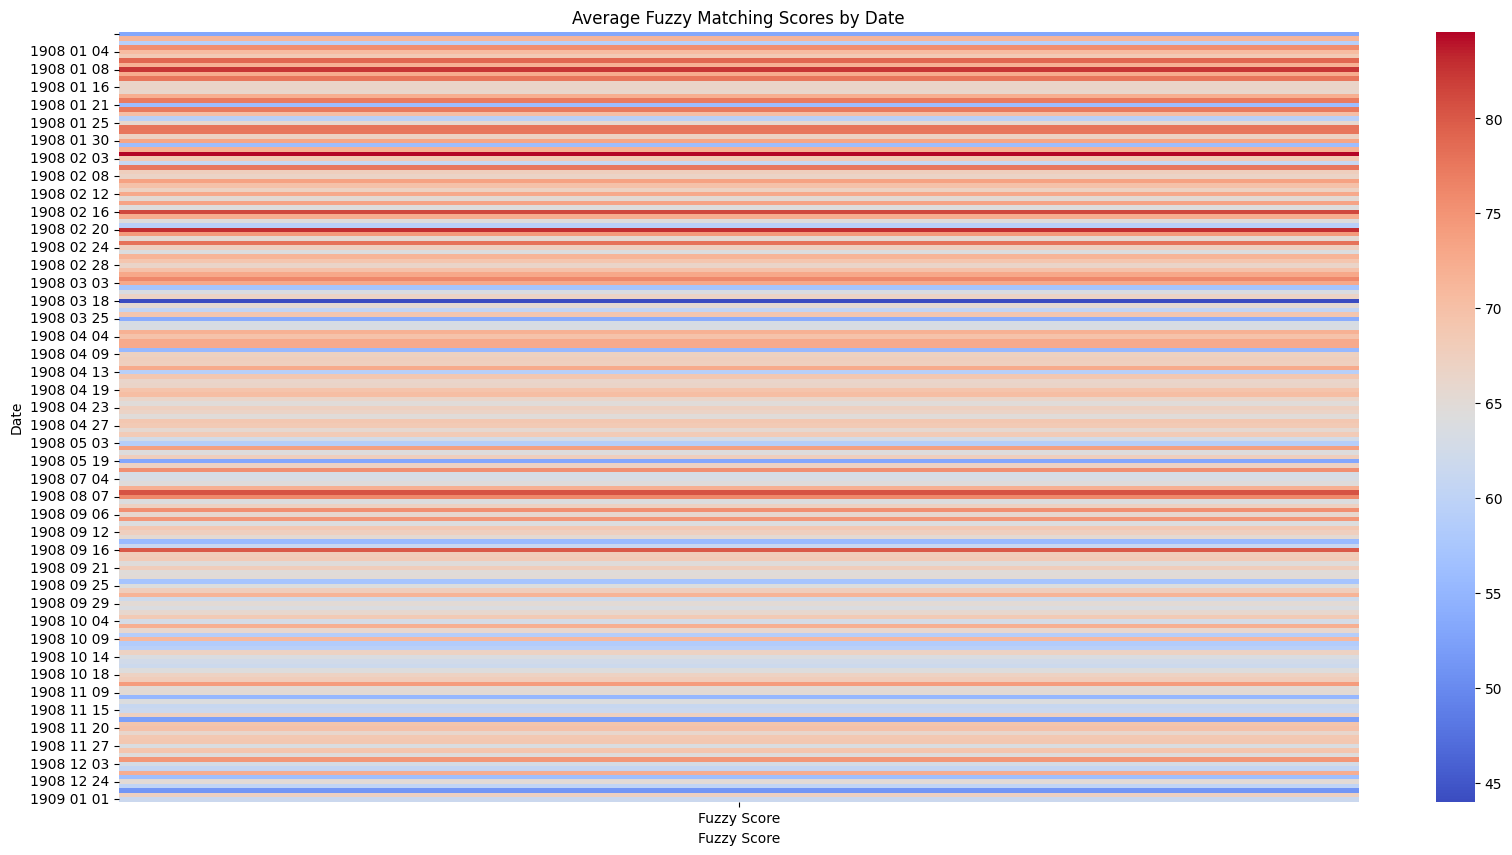

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the date directly from the dictionary in the 'JSON Record'
results_df['Date'] = results_df['JSON Record'].apply(lambda x: x['normalized_konsert_datum'])

# Ensure Fuzzy Score is in float format for averaging and visualization
results_df['Fuzzy Score'] = results_df['Fuzzy Score'].astype(float)

# Group and average the fuzzy scores by date for visualization
grouped_scores = results_df.groupby('Date')['Fuzzy Score'].mean().reset_index()

# Pivot the DataFrame to format suitable for a heatmap, filling NaNs if any with 0
pivot_table = grouped_scores.pivot_table(index='Date', values='Fuzzy Score', aggfunc='mean').fillna(0)

# Create the heatmap
plt.figure(figsize=(20, 10))  # Adjust the size as needed
sns.heatmap(pivot_table, annot=False, fmt=".1f", cmap='coolwarm')
plt.title('Average Fuzzy Matching Scores by Date')
plt.xlabel('Fuzzy Score')
plt.ylabel('Date')
plt.show()
